In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os
import json
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

In [2]:
db = global_connect()

## Load data

### Load unique itineraries and drivers from itineraries datasets

In [3]:
I1_i = set(careful_query("""
SELECT DISTINCT(itinerary_id) AS itineraries
FROM itineraries
WHERE distribution_center1 = 1;
""").itineraries.values)

I1_d = set(careful_query("""
SELECT DISTINCT(driver_id) AS drivers
FROM itineraries
WHERE distribution_center1 = 1;
""").drivers.values)

I2_i = set(careful_query("""
SELECT DISTINCT(itinerary_id) AS itineraries
FROM itineraries
WHERE distribution_center1 = 2;
""").itineraries.values)

I2_d = set(careful_query("""
SELECT DISTINCT(driver_id) AS drivers
FROM itineraries
WHERE distribution_center1 = 2;
""").drivers.values)

### Load unique itineraries and drivers from availabilities datasets

In [4]:
A1_i = set(careful_query("""
SELECT DISTINCT(itinerary_id) AS itineraries
FROM availabilities
WHERE distribution_center = 1;
""", 320000).itineraries.values)

A1_d = set(careful_query("""
SELECT DISTINCT(driver_id) AS drivers
FROM availabilities
WHERE distribution_center = 1;
""", 320000).drivers.values)

A2_i = set(careful_query("""
SELECT DISTINCT(itinerary_id) AS itineraries
FROM availabilities
WHERE distribution_center = 2;
""", 670000).itineraries.values)

A2_d = set(careful_query("""
SELECT DISTINCT(driver_id) AS drivers
FROM availabilities
WHERE distribution_center = 2;
""", 670000).drivers.values)


### Generate new dataframe with count unique information
- itinerary_id and driver_id are two main ID that relate the datasets, so we will look directly into them

In [5]:
data = {
        'A1': [len(A1_i),
               len(A1_d)],
        'A2': [len(A2_i),
               len(A2_d)],
        'A1 ∪ A2': [len(A1_i | A2_i),
                    len(A1_d | A2_d)],        
        'A1 ∩ A2': [len(A1_i & A2_i),
                    len(A1_d & A2_d)],
        'I1': [len(I1_i),
               len(I1_d)],
        'I2': [len(I2_i),
               len(I2_d)],
        'I1 ∪ I2': [len(I1_i | I2_i),
                    len(I1_d | I2_d)],
        'I1 ∩ I2': [len(I1_i & I2_i),
                    len(I1_d & I2_d)]
       }

df = pd.DataFrame(data, index=['unique itineraries', 'unique drivers'])

**Symbols reference**
- **A1**: agency 1 availabilities dataset
- **A2**: agency 2 availabilities dataset
- **I1**: agency 1 itineraries dataset
- **I2**: agency 2 itineraries dataset
- **∪**: union operator
- **∩**: intersection operator

 
  

In [6]:
df.style.applymap(lambda x: 'background-color:red; color:yellow' if x > 0 else '',
                subset = ['I1 ∩ I2', 'A1 ∩ A2'])

,A1,A2,A1 ∪ A2,A1 ∩ A2,I1,I2,I1 ∪ I2,I1 ∩ I2
unique itineraries,54465,175870,223792,6543,20991,12424,33415,0
unique drivers,6997,7992,8195,6794,1611,1238,2717,132


## Unique itineraries found in Loggi's datasets

In [7]:
colors = ['#99ff99', '#9999ff']
WEIGHTED = False

def plot6(sets):
    fig, axes = plt.subplots(2, 3, figsize=(16,9))
    axes = axes.flatten()
    for i, g in enumerate(sets):
        if WEIGHTED:
            venn2(list(g.values()), set_labels = list(g.keys()), set_colors=colors, ax=axes[i]);
            venn2_circles(list(g.values()), linewidth=1, ax=axes[i]);
        else:
            venn2_unweighted(list(g.values()), set_labels = list(g.keys()), set_colors=colors, ax=axes[i]);
            venn2_circles((1,1,1), linewidth=1, ax=axes[i]);

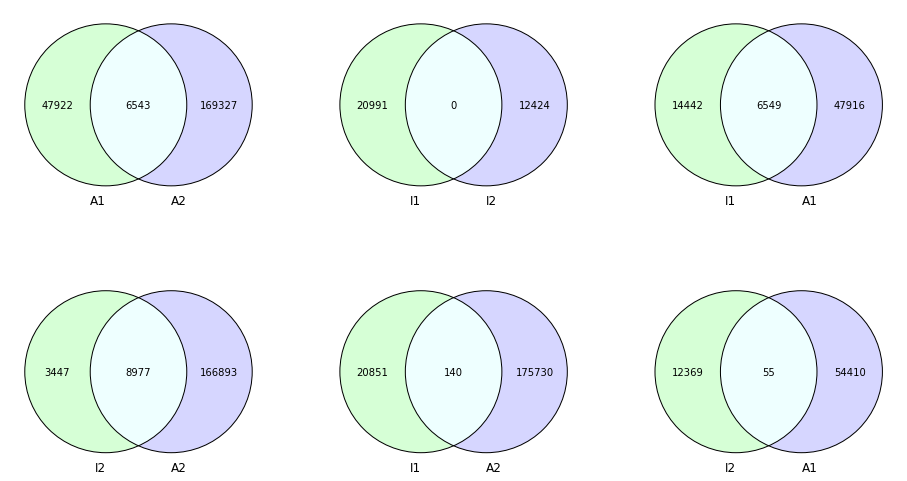

In [8]:
itineraries_sets = [
    {'A1': A1_i, 'A2': A2_i},
    {'I1': I1_i, 'I2': I2_i},
    {'I1': I1_i, 'A1': A1_i},
    {'I2': I2_i, 'A2': A2_i},
    {'I1': I1_i, 'A2': A2_i},
    {'I2': I2_i, 'A1': A1_i}
]
plot6(itineraries_sets)

**The above Venn's diagrams suggest that:**
- **A1, A2**: the intersection could be related to itineraries that started in some agency's area and ended in the other.
- **I1, I2**: there is no intersection here. So the itinerary owner is the agency.
- **I1, A1**: we have only near 30% of I1 itineraries in A1. (**TRUNCATED DATA**). But at the same time we have many more itineraries data in A1. Most of them could be not of type **PRO**.
- **I2, A2**: we have only near 72% of I2 itineraries in A2. (**TRUNCATED DATA**). But at the same time we have many more itineraries data in A1. Most of them could be not of type **PRO**.
- **I1, A2**: this is related with first observation here in A1, A2. 142 itineraries of I1 could be started, pass through or ended at the other agency zone.
- **I2, A1**: this is related with first observation here in A1, A2. 55 itineraries of I2 could be started, pass through or ended at the other agency zone.

**TRUNCATED DATA**:  
W have checked that most of the data truncated for agency 1 could be related to some kind of error when exporting (maybe someone forgot to consolidate the original availability dataset before exporting):
- **A1** data range goes from begining of year 2019 to march of 2020.
- **I1** present itineraries on a range that goes from october 2019 to march 2020.
- But the first itinerary of I1 in A1 taking into account the date appears on december 17 th, 2019. So **itineraries of I1 from october, november and part of december of 2019 were truncated in A1**.

## Unique drivers found in Loggi's datasets

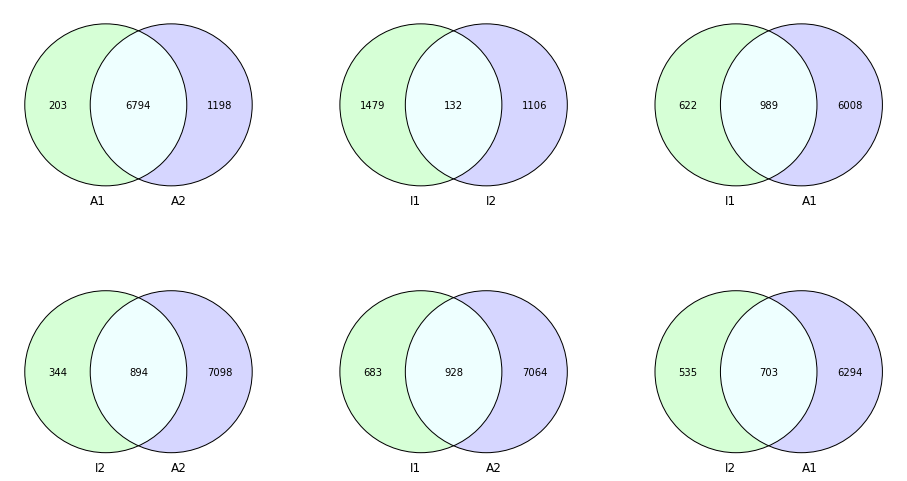

In [9]:
drivers_sets = [
    {'A1': A1_d, 'A2': A2_d},
    {'I1': I1_d, 'I2': I2_d},
    {'I1': I1_d, 'A1': A1_d},
    {'I2': I2_d, 'A2': A2_d},
    {'I1': I1_d, 'A2': A2_d},
    {'I2': I2_d, 'A1': A1_d}
]

plot6(drivers_sets)

**The above Venn's diagrams suggest that:**
- **A1, A2**: both agencies could share many drivers (at least there zones).
- **I1, I2**: but just few drivers have worked for both agencies!
- **I1, A1**: we have only near 61% of I1 drivers in A1. **(TRUNCATED DATA)**. But at the same time we have many more drivers data in A1. Most of them could be drivers that do not work for deliveries of type **PRO**.
- **I2, A2**: we have only near 72% of I2 drivers in A2. **(TRUNCATED DATA)**. But at the same time we have many more drivers data in A1. Most of them could be drivers that do not work for deliveries of type **PRO**.
- **I1, A2**: 57.6% of drivers of agency 1 have appeared at leat one time in the other agency zone. Most important is that **42.4% of drivers of agency 1 never entered agency 2 zone!**
- **I2, A1**: 56.7% of drivers of agency 1 have appeared at leat one time in the other agency zone. Most important is that **43.3% of drivers of agency 1 never entered agency 2 zone!**  
(*) Very similar ratio in last two observations about drivers


Almost the total number of drivers are presented in both availabilities datasets, but just 132 of have worked for both agencies. So will be really important to follow the drivers in both availabilities datasets knowing whom the driver is working for. We know that in itineraries we have only those that are of product type 'PRO'. Maybe there are drivers that work for both agencies doing other kind of deliveries. **In any way, we think marking drivers with most probable agency could be of relevance when counting them as really available**. For our porpouse we could add two columns to availabilities (weight_1, weight_2) assigning to them (for each agency based on itineraries information) the driver_number_of_itineraries_for_agency_X / total_driver_numer_of_itineraries. We could test different date ranges to eval this classification. For example these weights for: total lifespan, last 3 months, last 30 days, last 15 days, last week, etc.

```
# pseudo code to calculate driver's agency weights
def calculate_drivers_weights(period=('2019-01-01', '2020-01-01')):
    for each driver_id in drivers_in(I1 | I2, period=period):
        i1 = count_driver_itineraries_at(driver_id, I1, period)
        i2 = count_driver_itineraries_at(driver_id, I2, period)
        if i1 + i2 == 0:
            raise exception('Error: driver found in I1 or I2 with no itineraries :S')
        agency1_weight = i1 / (i1+i2)
        agency2_weight = i2 / (i1+i2)
        save_driver_weights(driver_id, agency1_weight, agency2_weight)
```

It is important to think about how and when to calculate drivers weights. If we calculate it once a day taking into account last 30 days, then the weights will vary daily. If we calculate it once a month taking into account last 30 days, then it will vary monthly. These weights will be usefull when selecting the number of available drivers for an agency.